In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [264]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [265]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.4.0


In [266]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [267]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [268]:
# data_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/sketchy_data/'
data_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/sketchy_data/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/airplane_c1_1'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/data5'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/layer_norm_1000/trained_data10'
# model_dir = '/home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/lstm_1000/trained_data2'
# model_dir = '/tmp/sketch_rnn/models/default/'

In [269]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [270]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 400/50/90 from airplane_c1_ep3.npz
INFO:tensorflow:Dataset combined: 540 (400/50/90), avg len 71
INFO:tensorflow:model_params.max_seq_len 100.
total images <= max_seq_len is 400
total images <= max_seq_len is 50
total images <= max_seq_len is 90
INFO:tensorflow:normalizing_scale_factor 96.4830.


In [271]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [272]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [273]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/airplane_c1_1/vector-22000.
INFO:tensorflow:Restoring parameters from /home/kelvin/OgataLab/magenta/magenta/models/sketch_rnn/airplane_c1_1/vector-22000


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [274]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=100).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  print("in encode(): seq_len = {}".format(seq_len))
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [275]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

(100, 3)


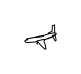

In [276]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
print(stroke.shape)
draw_strokes(stroke)

Let's try to encode the sample stroke into latent vector $z$

in encode(): seq_len = [100]


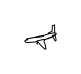

In [277]:
z = encode(stroke)

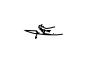

In [278]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

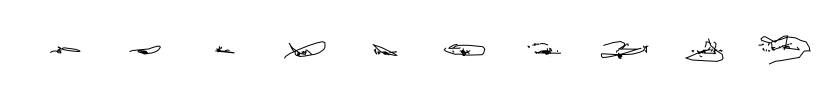

In [279]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

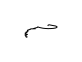

In [280]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

in encode(): seq_len = [49]


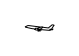

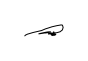

In [281]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [282]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [283]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

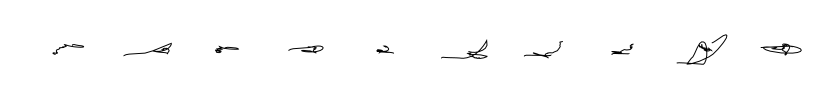

In [284]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [285]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [286]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [287]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [288]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [289]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector


In [290]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

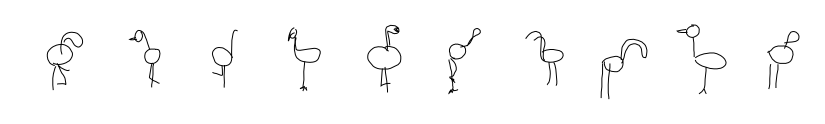

In [291]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [292]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [293]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/owl/lstm/vector


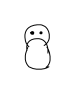

In [294]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

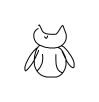

In [295]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [296]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

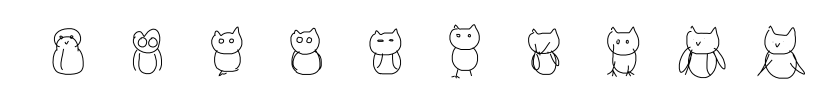

In [297]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [298]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [299]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/catbus/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/catbus/lstm/vector


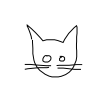

In [300]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

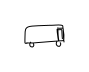

In [301]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [302]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

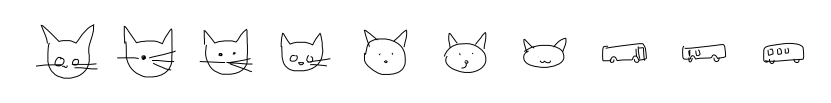

In [303]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [304]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [305]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm/vector


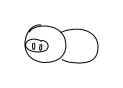

In [306]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

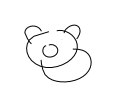

In [307]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [308]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [309]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

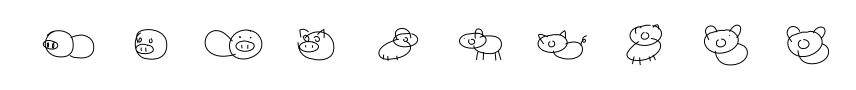

In [310]:
draw_strokes(stroke_grid, factor=0.3)